## Data Retrieval

Yahoo Finance API is used to get stocks data for Google over period of seven years. 

In [7]:
import yahoo_finance as yahoo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display # Allows the use of display() for DataFrames

from matplotlib.dates import DateFormatter, WeekdayLocator,\
    DayLocator, MONDAY
from matplotlib.finance import candlestick_ohlc


# Show matplotlib plots inline (nicely formatted in the notebook)
%matplotlib inline

# Control the default size of figures in this Jupyter notebook
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 9)

###### Entry Parameters #######
startDate = '2010-01-01'
endDate = '2017-01-01'
ticker = 'GOOG'

#Used for re-running: stops querying the API if we already have the data
fetchData = False

#Stock Data- first step is to obtain the list of stocks, and then select a stock to run through machine learning
fileName = 'data/stocksData.csv'
###############################

# returive stock data using yahoo Finance API and return a dataFrame
def retrieveStockData():
    try:
        if fetchData:
            #for symbol in ['GOOG']:
            print('Retriving data for ticker _GOOG...')
            data = pd.DataFrame(yahoo.Share(tickerSymbol).get_historical(startDate, endDate))

            # save as CSV to stop blowing up their API
            data.to_csv(fileName, index_col=None, header=0, parse_dates=['Date'])
        else:
            # read the existing csv 
            data = pd.read_csv(fileName)

        data.fillna(method='ffill', inplace=True)
        data.fillna(method='bfill', inplace=True)
        #Date and Symbol columns not required
        data.drop(['Symbol', 'Index'], axis = 1, inplace = True)
        pd.to_datetime(data['Date'])
        # make date as an index for pandas data frame
        data.set_index('Date',inplace=True)
        print "Wholesale customers dataset has {} samples with {} features each.".format(*data.shape)
        return data 
    except:
         print "Dataset could not be loaded. Is the dataset missing?"
        

data = retrieveStockData()

display(data.head())


Populating the interactive namespace from numpy and matplotlib
Wholesale customers dataset has 1762 samples with 6 features each.


,Open,Close,Adj_Close,High,Low,Volume
Date,,,,,,
2010-01-04,626.951088,626.751061,313.062468,629.511067,624.241073,3927000
2010-01-05,627.181073,623.991055,311.683844,627.841071,621.541045,6031900
2010-01-06,625.861078,608.261023,303.826685,625.861078,606.361042,7987100
2010-01-07,609.401025,594.101005,296.753749,610.001045,592.651008,12876600
2010-01-08,592.000997,602.021036,300.709808,603.251034,589.110988,9483900


## Data Exploration

Let’s briefly describe data features. 
**Open** is the price of the stock at the beginning of the trading day (it need not be the closing price of the previous trading day), 
**high** is the highest price of the stock on that trading day, 
**low** the lowest price of the stock on that trading day, and 
**close** the price of the stock at closing time. 
**Volume** indicates how many stocks were traded. 
**Adjusted close** is the closing price of the stock that adjusts the price of the stock for corporate actions. While stock prices are considered to be set mostly by traders, stock splits (when the company makes each extant stock worth two and halves the price) and dividends (payout of company profits per share) also affect the price of a stock and should be accounted for.

In this section I will explore the data through visualizations and code to understand how each feature is related to the others. I will observe a statistical description of the dataset, consider the relevance of each feature, and select a few sample data points from the dataset which you will track through the course of this project.


In [8]:
# Display a description of the dataset
display(data.describe())

,Open,Close,Adj_Close,High,Low,Volume
count,1762.000000,1762.000000,1762.000000,1762.000000,1762.000000,1.762000e+03
mean,667.988556,667.732200,460.416137,673.341401,662.013391,4.051175e+06
std,159.812252,159.790218,173.765480,160.469786,159.052972,2.933264e+06
min,438.310758,436.070761,217.817563,442.280760,433.630737,7.900000e+03
25%,548.639605,547.364993,299.208801,553.582514,542.753834,1.901175e+06
50%,613.846067,614.161057,437.910342,619.111038,609.356057,3.642400e+06
75%,749.962820,749.452515,579.082539,756.218456,742.882817,5.165425e+06
max,1226.802152,1220.172036,813.109985,1228.882066,1218.602083,2.976060e+07


The first thing I notice here is that the mean values and median values differ a lot. 
That means the distribution should not be a normal distribution. In such a case, median is considered to be more reiable than mean.

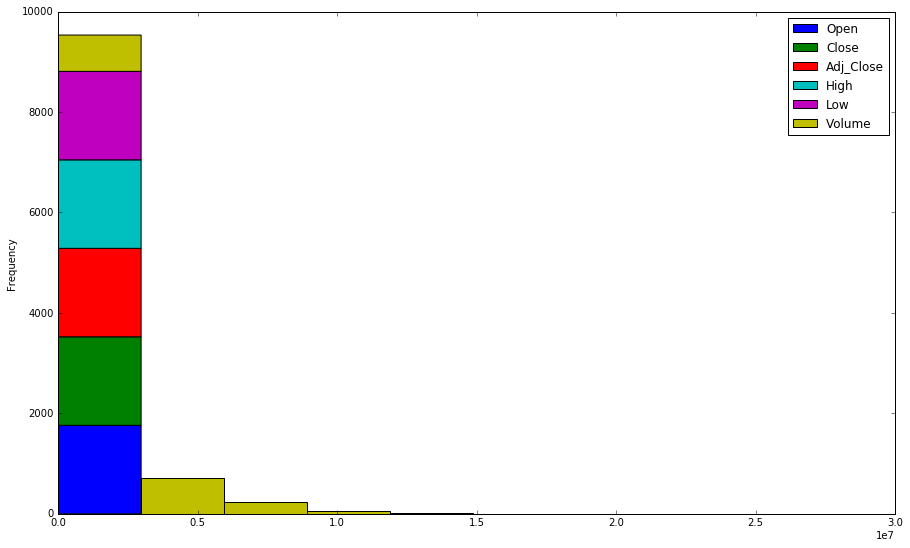

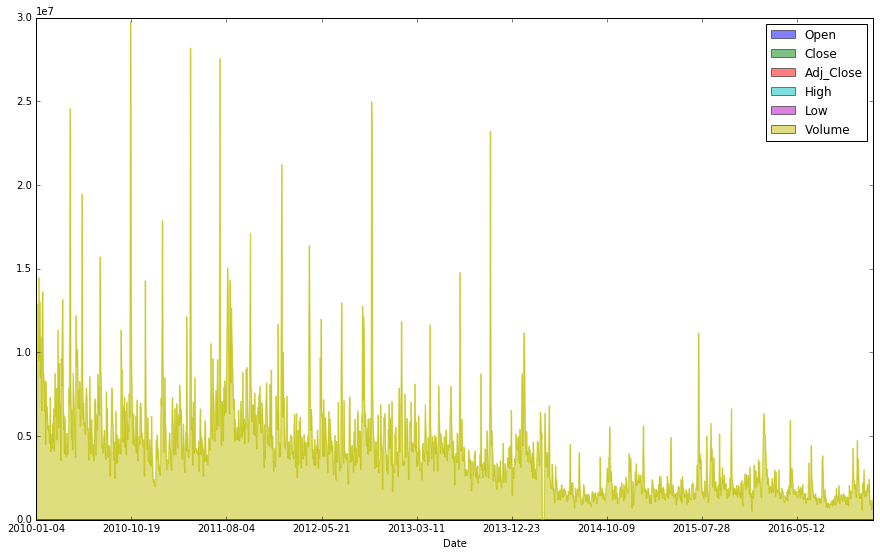

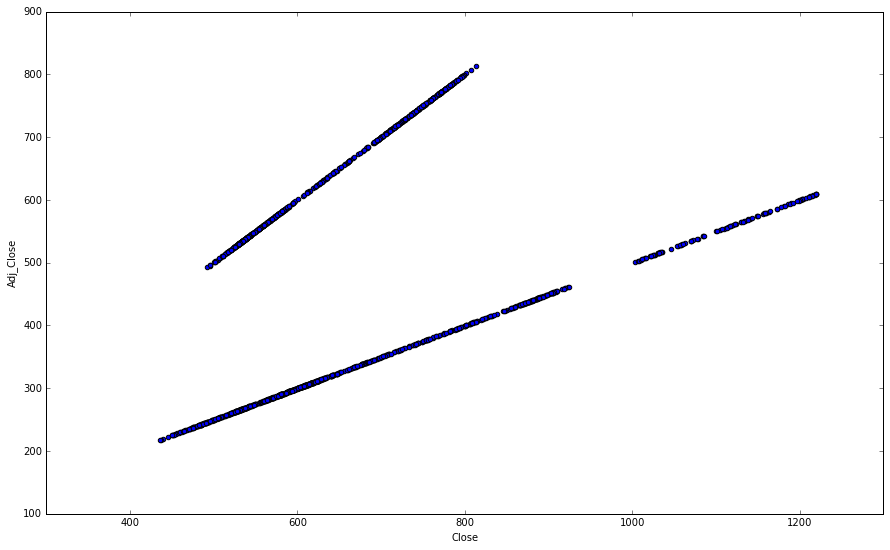

In [9]:
plt.figure();
data.plot.hist(stacked=True)
data.plot.area(stacked=False);
data.plot.scatter(x='Close', y='Adj_Close');

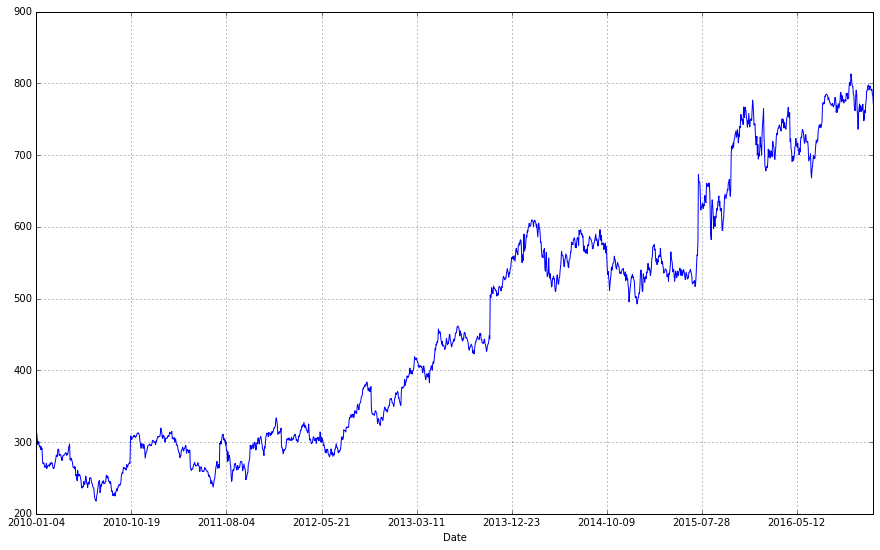

In [10]:
data["Adj_Close"].plot(grid = True)

We can observe the price changes of Google stock in seven years. We see in general the price of Google stocks has been increased. We can observe some drops and spikes in visualization also. Mostly in 2013 and 2015.

TypeError: unsupported operand type(s) for -: 'str' and 'str'

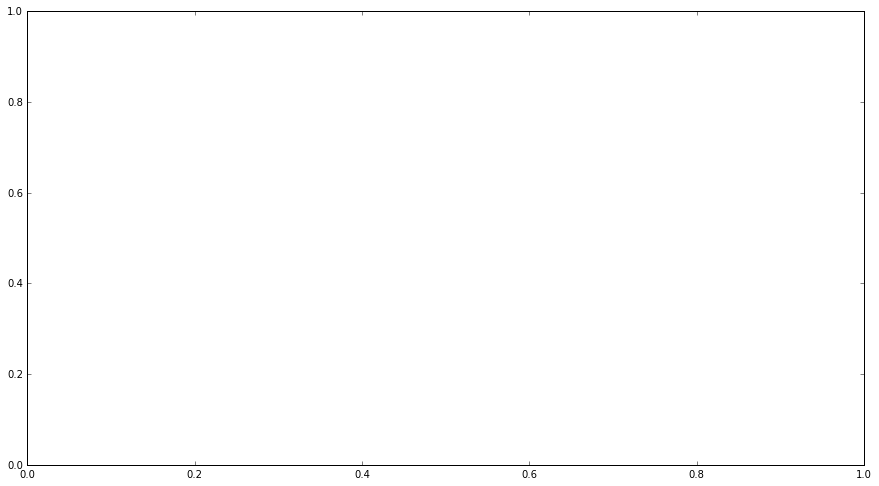

In [11]:
def pandas_candlestick_ohlc(dat, stick = "day", otherseries = None):
    """
    :param dat: pandas DataFrame object with datetime64 index, and float columns "Open", "High", "Low", and "Close", likely created via DataReader from "yahoo"
    :param stick: A string or number indicating the period of time covered by a single candlestick. Valid string inputs include "day", "week", "month", and "year", ("day" default), and any numeric input indicates the number of trading days included in a period
    :param otherseries: An iterable that will be coerced into a list, containing the columns of dat that hold other series to be plotted as lines
 
    This will show a Japanese candlestick plot for stock data stored in dat, also plotting other series if passed.
    """
    mondays = WeekdayLocator(MONDAY)        # major ticks on the mondays
    alldays = DayLocator()              # minor ticks on the days
    dayFormatter = DateFormatter('%d')      # e.g., 12
 
    # Create a new DataFrame which includes OHLC data for each period specified by stick input
    transdat = dat.loc[:,["Open", "High", "Low", "Close"]]
    if (type(stick) == str):
        if stick == "day":
            plotdat = transdat
            stick = 1 # Used for plotting
        elif stick in ["week", "month", "year"]:
            if stick == "week":
                transdat["week"] = pd.to_datetime(transdat.index).map(lambda x: x.isocalendar()[1]) # Identify weeks
            elif stick == "month":
                transdat["month"] = pd.to_datetime(transdat.index).map(lambda x: x.month) # Identify months
            transdat["year"] = pd.to_datetime(transdat.index).map(lambda x: x.isocalendar()[0]) # Identify years
            grouped = transdat.groupby(list(set(["year",stick]))) # Group by year and other appropriate variable
            plotdat = pd.DataFrame({"Open": [], "High": [], "Low": [], "Close": []}) # Create empty data frame containing what will be plotted
            for name, group in grouped:
                plotdat = plotdat.append(pd.DataFrame({"Open": group.iloc[0,0],
                                            "High": max(group.High),
                                            "Low": min(group.Low),
                                            "Close": group.iloc[-1,3]},
                                           index = [group.index[0]]))
            if stick == "week": stick = 5
            elif stick == "month": stick = 30
            elif stick == "year": stick = 365
 
    elif (type(stick) == int and stick >= 1):
        transdat["stick"] = [np.floor(i / stick) for i in range(len(transdat.index))]
        grouped = transdat.groupby("stick")
        plotdat = pd.DataFrame({"Open": [], "High": [], "Low": [], "Close": []}) # Create empty data frame containing what will be plotted
        for name, group in grouped:
            plotdat = plotdat.append(pd.DataFrame({"Open": group.iloc[0,0],
                                        "High": max(group.High),
                                        "Low": min(group.Low),
                                        "Close": group.iloc[-1,3]},
                                       index = [group.index[0]]))
 
    else:
        raise ValueError('Valid inputs to argument "stick" include the strings "day", "week", "month", "year", or a positive integer')
 
 
    # Set plot parameters, including the axis object ax used for plotting
    fig, ax = plt.subplots()
    fig.subplots_adjust(bottom=0.2)
    #print(int(plotdat.index[-1]) - int(plotdat.index[0]) )
    if plotdat.index[-1] - plotdat.index[0] < pd.Timedelta('730 days'):
        print( plotdat.index[-1] - plotdat.index[0], pd.Timedelta('730 days'))
        weekFormatter = DateFormatter('%b %d')  # e.g., Jan 12
        ax.xaxis.set_major_locator(mondays)
        ax.xaxis.set_minor_locator(alldays)
    else:
        weekFormatter = DateFormatter('%b %d, %Y')
    ax.xaxis.set_major_formatter(weekFormatter)
 
    ax.grid(True)
 
    # Create the candelstick chart
    candlestick_ohlc(ax, list(zip(list(date2num(plotdat.index.tolist())), plotdat["Open"].tolist(), plotdat["High"].tolist(),
                      plotdat["Low"].tolist(), plotdat["Close"].tolist())),
                      colorup = "black", colordown = "red", width = stick * .4)
 
    # Plot other series (such as moving averages) as lines
    if otherseries != None:
        if type(otherseries) != list:
            otherseries = [otherseries]
        dat.loc[:,otherseries].plot(ax = ax, lw = 1.3, grid = True)
 
    ax.xaxis_date()
    ax.autoscale_view()
    plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
 
    plt.show()
 
pandas_candlestick_ohlc(data)

### Implementation: Selecting Samples

To get a better understanding of stock data and how this data will transform through the analysis, it would be best to select a few sample data points and explore them in more detail. In the code block below, add three indices to the indices list which will represent the stocks to track. 
It is suggested to try different sets of samples until you obtain customers that vary significantly from one another.

In [ ]:
# Select three indices to sample from the dataset
indices = ['2010-01-04', '2011-01-04', '2016-01-04']

# Create a DataFrame of the chosen samples
samples = pd.DataFrame(data.loc[indices], columns = data.keys()).reset_index(drop = True)

print "Chosen samples of Google stock dataset:"
display(samples)

### Calculating percentile change

In [12]:
#whats of interest here is the percentage change from one day to the next
data = data.pct_change()

display(data.head())

,Open,Close,Adj_Close,High,Low,Volume
Date,,,,,,
2010-01-04,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,0.000367,-0.004404,-0.004404,-0.002653,-0.004325,0.536007
2010-01-06,-0.002105,-0.025209,-0.025209,-0.003154,-0.024423,0.324143
2010-01-07,-0.026300,-0.023280,-0.023280,-0.025341,-0.022610,0.612175
2010-01-08,-0.028553,0.013331,0.013331,-0.011066,-0.005973,-0.263478


## Feature Relevance 

In [13]:
for col in list(data.columns.values):    
    # Make a copy of the DataFrame, using the 'drop' function to drop the given feature
    new_data = data.drop(col, axis=1)

    # Split the data into training and testing sets using the given feature as the target
    from sklearn.cross_validation import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(new_data, data[col], test_size=0.25, random_state=42)

    # Create a decision tree regressor and fit it to the training set
    from sklearn.tree import DecisionTreeRegressor
    regressor = DecisionTreeRegressor(random_state=0)
    regressor.fit(X_train, y_train)

    # Report the score of the prediction using the testing set
    score = regressor.score(X_test, y_test)
    print("{} R^2 score: {:2f}".format(col ,score))

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

The coefficient of determination, R^2, is scored between 0 and 1, with 1 being a perfect fit. A negative R^2 implies the model fails to fit the data. 

Based on the R^2 score looks like between Open, Close and Adjacent Close prices; Close has the highest relevancy and it is best to use this to determine prediction.
Volume has the lowest score which makes it not being much useful for our predictions since the model couldn't fit trying to predict them using the others.

### Visualize Feature Distributions

To get a better understanding of the dataset, we can construct a scatter matrix of each of the six stock features present in the data. 
If we found that the feature you attempted to predict above is relevant for identifying a specific customer, then the scatter matrix below may not show any correlation between that feature and the others. Conversely, if we believe that feature is not relevant for identifying a specific customer, the scatter matrix might show a correlation between that feature and another feature in the data.

In [ ]:
# Produce a scatter matrix for each pair of features in the data
pd.scatter_matrix(data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

## Identifying outliers
Outliers are data points that are distinctvely separated from other data points any data point more than 1.5 interquartile ranges (IQRs) below the first quartile or above the third quartile.

Outliers has the biggest effect on the mean but not much effect on the median. Effecting mean can lead to effecting variance and then having largest effect on standard deviation.

In [ ]:
#locate number of outliers for each column, outlier being 1.5 IQR up or down from upper or lower quartile
outliers = pd.DataFrame(index=data.index)
outliers = pd.DataFrame(np.where(
        (data > 1.5 * ((data.quantile(0.75) - data.quantile(0.25)) + data.quantile(0.75))) |
        (data < 1.5 * (data.quantile(0.25) - (data.quantile(0.75)) - data.quantile(0.25))),1, 0), 
                        columns=data.columns)

#transpose the describe so that columns can be added
res = data.describe().transpose()

display(res)

In [ ]:
res['variance'] = data.var()
res['outliers'] = outliers.sum()
res['mean_x_outliers'] = (1/res['outliers'])*res['mean']


display(res['variance'])
display(res['outliers'])
display(res['mean_x_outliers'])

## Define worthiness of a trade
Below is a function which determines variance of a trade means how much a trade worth. Which is risk vs reward or in another words, difference in expected return vs actual return on an investment.

In [ ]:
def varianceOfReturn(endPrice, actualPrice, predictedPrice):
    t1 = abs(actualPrice- endPrice)
    p1 = abs(predictedPrice-actualPrice)
    return (p1/t1)*100.0


## Build an Stock Predictor

In [ ]:
from keras.layers import Dense, LSTM
from keras.models import Sequential

from sklearn import svm, metrics, preprocessing
import datetime as dt
import pandas as pd
import numpy as np
import yahoo_finance as yahoo
from sklearn.cross_validation import train_test_split, ShuffleSplit
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Show matplotlib plots inline (nicely formatted in the notebook)
import matplotlib.pyplot as plt


class StockPredictor:

    def __init__(self, APIKey):
        quandl.ApiConfig.api_key = APIKey
        self.tickerSymbol = ''

    #LoadData call queries the API, caching if necessary
    def loadData(self, tickerSymbol, startDate, endDate, reloadData=False, fileName='stockData.csv'):

        self.tickerSymbol = tickerSymbol
        self.startDate = startDate
        self.endDate = endDate

        if reloadData:
            #get data from yahoo finance fo tickerSymbol
            data = pd.DataFrame(yahoo.Share(tickerSymbol).get_historical(startDate, endDate))

            # save as CSV to stop blowing up their API
            data.to_csv(fileName)

            # save then reload as the yahoo finance date doesn't load right in Pandas
            data = pd.read_csv(fileName)
        else:
            data = pd.read_csv(fileName)

        # Due to differing markets and timezones, public holidays etc (e.g. BHP being an Australian stock,
        # ASX doesn't open on 26th Jan due to National Holiday) there are some gaps in the data.
        # from manual inspection and knowledge of the dataset, its safe to take the previous days' value
        data.fillna(method='ffill', inplace=True)
        self.data = data

    #preparedata call does the preprocessing of the loaded data
    #sequence length is a tuning parameter - this is the length of the sequence that will be trained on.
    # Too long and too short and the algorithms won't be able to find any trend - set as 5 days
    # by default, and this works pretty well
    def prepareData(self, predictDate, metric = 'Adjusted Close', sequenceLength=5):

        # number of days to predict ahead
        predictDate = dt.datetime.strptime(predictDate, "%Y-%m-%d")
        endDate = dt.datetime.strptime(self.endDate, "%Y-%m-%d")

        #this pandas gets the number of business days ahead, within reason ( i.e. doesn't know about local market
        #public holidays, etc)
        self.numBdaysAhead = abs(np.busday_count(predictDate, endDate))
        print "business days ahead", self.numBdaysAhead

        self.sequenceLength = sequenceLength
        self.predictAhead = self.numBdaysAhead
        self.metric = metric

        data = self.data
        # Calculate date delta
        data['Date'] = pd.to_datetime(data['Date'])
        data['date_delta'] = (data['Date'] - data['Date'].min()) / np.timedelta64(1, 'D')

        #create the lagged dataframe
        tslag = pd.DataFrame(index=data.index)

        #use the shift function to get the price x days ahead, and then transpose
        for i in xrange(0, sequenceLength + self.numBdaysAhead):
            tslag["Lag%s" % str(i + 1)] = data[metric].shift(1 - i)

        #shift (-2) then corrects the sequence indexes
        tslag.shift(-2)
        tslag['date_delta'] = data['date_delta']

        # create the dataset.  This will take the first [sequenceLength] columns as the data, and the
        # value at end of sequence + number days ahead as the label
        trainCols = ['date_delta']
        for i in xrange(0, sequenceLength):
            trainCols.append("Lag%s" % str(i + 1))
        labelCol = 'Lag' + str(sequenceLength + self.numBdaysAhead)

        # get the final row for predictions
        rowcalcs = tslag[trainCols]
        rowcalcs = rowcalcs.dropna()

        #need an unscaled version for the RNN
        self.final_row_unscaled = rowcalcs.tail(1)


        #due to the way the lagged set is created, there will be some rows with nulls for where
        #the staggering has not worked to to predicting too far back, or ahead.
        #  We can drop these without losing any information as these sequences will be represented in
        #other rows within the dataset
        tslag.dropna(inplace=True)

        label = tslag[labelCol]
        new_data = tslag[trainCols]

        # print "NEW DATA", new_data.tail(1)
        #scale the data for the Linear Regression, SVR and Neural Net
        self.scaler = preprocessing.StandardScaler().fit(new_data)
        scaled_data = pd.DataFrame(self.scaler.transform(new_data))

        # print "SCALED DATA", scaled_data.tail(1)
        self.scaled_data = scaled_data
        self.label = label

    #Linear Regression trainer
    def trainLinearRegression(self):
        lr = LinearRegression()
        X_train, X_test, y_train, y_test = train_test_split(self.scaled_data, self.label, test_size=0.25,
                                                            random_state=42)

        parameters = {'fit_intercept': [True, False], 'normalize': [True, False], 'copy_X': [True, False]}

        grid = GridSearchCV(lr, parameters, cv=None)
        grid.fit(X_train, y_train)
        predicttrain = grid.predict(X_train)
        predicttest = grid.predict(X_test)
        print "R2 score for training set (Linear Regressor): {:.4f}.".format(r2_score(predicttrain, y_train))
        print "R2 score for test set (Linear Regressor): {:.4f}.".format(r2_score(predicttest, y_test))
        self.model = grid

    #predict Linear Regression
    def predictLinearRegression(self):
        inputSeq = self.scaler.transform(self.final_row_unscaled)
        inputSeq = pd.DataFrame(inputSeq)
        predicted = self.model.predict(inputSeq)[0]
        return predicted


    def trainSVR(self):
        clf = svm.SVR()
        X_train, X_test, y_train, y_test = train_test_split(self.scaled_data, self.label, test_size=0.25, random_state=42)

        parameters = {'C': [1, 10], 'epsilon': [0.1, 1e-2, 1e-3]}
        r2_scorer = metrics.make_scorer(metrics.r2_score)

        grid_obj = GridSearchCV(clf, param_grid=parameters, scoring=r2_scorer)
        grid_obj.fit(X_train, y_train)
        print "best svr params", grid_obj.best_params_

        predicttrain = grid_obj.predict(X_train)
        predicttest = grid_obj.predict(X_test)

        print "R2 score for training set (SVR): {:.4f}.".format(r2_score(predicttrain, y_train))
        print "R2 score for test set (SVR): {:.4f}.".format(r2_score(predicttest, y_test))
        self.model = grid_obj

    def predictSVR(self):
        inputSeq = self.scaler.transform(self.final_row_unscaled)
        inputSeq = pd.DataFrame(inputSeq)
        predicted = self.model.predict(inputSeq)[0]
        return predicted


    def trainNN(self):
        X_train, X_test, y_train, y_test = train_test_split(self.scaled_data.as_matrix(), self.label.as_matrix(), test_size=0.25, random_state=42)

        # create model
        model = Sequential()
        model.add(Dense(270, input_dim=X_train.shape[1], init='normal', activation='relu'))
        model.add(Dense(1, init='normal', activation='linear'))

        #this is handy to visualise the model
        print model.summary()

        # Compile model
        model.compile(loss='mean_absolute_error', optimizer='rmsprop')
        model.fit(X_train, y_train, nb_epoch=150, batch_size=25, verbose=0)

        predicttest = model.predict(X_test)
        predicttrain = model.predict(X_train)

        print "R2 score for training set (NN): {:.4f}.".format(r2_score(predicttrain, y_train))
        print "R2 score for test set (NN): {:.4f}.".format(r2_score(predicttest, y_test))
        self.model = model


    def predictNN(self):
        inputSeq = self.scaler.transform(self.final_row_unscaled)
        print "inputseq", inputSeq
        predicted = self.model.predict(inputSeq)[0][0]
        print "Predicted", predicted
        return predicted


    def trainRNN(self):
        #need unscaled data for the RNN
        colmn = self.data[self.metric]
        colmn = colmn.values
        print "last 3 cols", colmn[-1]
        self.maxlen = 7

        #self.step = 1
        self.step = self.numBdaysAhead-1

        #batch size tuning parameter
        self.batch_size = 50
        X = []
        y = []
        # as above, need to create data and labels for the RNN.
        for i in range(0, len(colmn) - self.step-self.maxlen):
            X.append(colmn[i: i + self.maxlen])
            y.append(colmn[i + self.step+self.maxlen])
        #print('nb sequences:', len(X))

        #convert lists to np arrays
        X = np.array(X)
        y = np.array(y)

        #convert to 3D and 2D tensors for processing by RNN
        X = np.reshape(X, X.shape + (1,))
        y = np.reshape(y, y.shape + (1,))

        #print('X_train shape:', X.shape)
        #print('X_test shape:', y.shape)

        #print "X and y", X[-1], y[-1]
        X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                            test_size=0.25, random_state=42)

        model = Sequential()
        model.add(LSTM(50,
                       batch_input_shape=(self.batch_size, self.maxlen, 1),
                       return_sequences=True))
        model.add(LSTM(50,
                       batch_input_shape=(self.batch_size, self.maxlen, 1),
                       return_sequences=False))
        model.add(Dense(1, init='normal', activation='linear'))

        print model.summary()
        # Compile model
        model.compile(loss='mean_absolute_error', optimizer='rmsprop')

        model.fit(X_train, y_train, nb_epoch=150, batch_size=25, verbose=0)

        predicttest = model.predict(X_test)
        predicttrain = model.predict(X_train)

        print "R2 score for training set (RNN): {:.4f}.".format(r2_score(predicttrain, y_train))
        print "R2 score for test set (RNN): {:.4f}.".format(r2_score(predicttest, y_test))
        self.model = model


    def predictRNN(self):
        #need unscaled data for prediction, fetch the last row, with batch size
        cols = self.data[self.metric].tail(self.batch_size*self.maxlen)
        cols = cols.values
        #translate these into the required format
        X = []
        for i in range(0, len(cols)-self.maxlen+1):
            X.append(cols[i: i + self.maxlen])

        #take last row and convert to np array
        inputSeq = np.array([X[-1]])
        #reshape to 3D tensor for RNN
        inputSeq = np.reshape(inputSeq, inputSeq.shape + (1,))
        predicted = self.model.predict(inputSeq)[0][0]
        return predicted


